# Introduction

In this notebook, I will fuzzify all market state parameters and build a FuzzyStateVector which determines the current state of the market.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# import requires packages
# Append relative path to FuzzyMarketState.py
import sys
sys.path.append('..')

from FuzzyMarketState import FuzzyMarketState

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.graph_objs import *
from plotly.tools import FigureFactory as FF
import plotly.tools as tls
plotly.offline.init_notebook_mode(connected=True)

import logging
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout)

import random

# Create object
fms = FuzzyMarketState(logging.WARN)

# load dataframe
df = fms.loadCSV('../csv_data/EURUSD_H4.csv', sep=';')
fms.loadDataframe(df)
df_crisp = fms.buildIndicators()

print('Packages loaded!!')

Packages loaded!!


### Zigzag fuzzification

Zigzag indicator includes: 

- Zigzag flips
- Bollinger indicators

Based on these indicators, several fuzzy parameters can be sinthetically built, as:


In [39]:
fms.setLoggingLevel(logging.WARN)
_df = fms.fuzzifyZigzag(timeperiod=50)

##### Duration of Zigzag flip:

Evaluates last N zigzags durations and according with its min-max range, fuzzifies into these 5 categories:

- VerySmall
- SlightlySmall
- Similar
- SlightlyLarge
- VeryLarge


In [42]:
data = fms.plotFuzzyZigzagVariable(var='DURATION_1')
py.iplot(data, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


In [43]:
data = fms.plotFuzzyZigzagVariable(var='DURATION_2')
py.iplot(data, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


##### Range of Zigzag flip:

Evaluates last N zigzags flip range according with its direction and fuzzifies into these 5 categories:

- VerySmall
- SlightlySmall
- Similar
- SlightlyLarge
- VeryLarge



In [58]:
data = fms.plotFuzzyZigzagVariable(var='RANGE')
py.iplot([data[1], data[2], data[3], data[4], data[5]], filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


In [30]:
# Use index as a sample count difference between zigzags
_df1 = df_zz.reset_index().copy()
_df2 = df_zz.reset_index().shift(1).copy()
_df1['ZZ_RANGE_ABS'] = _df1.ZIGZAG - _df2.ZIGZAG
_df1['ZZ_RANGE_POS'] = _df1.apply(lambda x: x.ZZ_RANGE_ABS if x.ZZ_RANGE_ABS > 0.0 else 0.0, axis=1)
_df1['ZZ_RANGE_NEG'] = _df1.apply(lambda x: x.ZZ_RANGE_ABS if x.ZZ_RANGE_ABS < 0.0 else 0.0, axis=1)
_df1.tail()


index   ZIGZAG ACTION  ZZ_RANGE_ABS  ZZ_RANGE_POS  ZZ_RANGE_NEG
302   6408  1.11177    low      -0.02060       0.00000      -0.02060
303   6434  1.12647   high       0.01470       0.01470       0.00000
304   6444  1.11350    low      -0.01297       0.00000      -0.01297
305   6475  1.12535   high       0.01185       0.01185       0.00000
306   6515  1.11419    low      -0.01116       0.00000      -0.01116

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


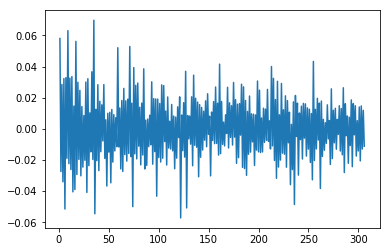

In [31]:
_df1['ZZ_RANGE_ABS'].plot()

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


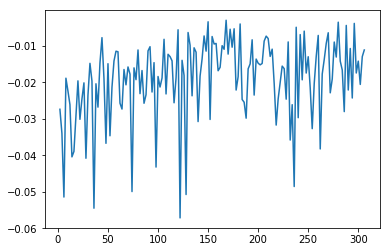

In [28]:
neg_dif = dif[dif < 0]
neg_dif.plot()

##### Bollinger overbought-oversell state:

Evaluates bollinger_%b indicator and fuzzifies into these 7 categories:

- InOverSell
- VeryPositive
- SlightlyPositive
- InTheMiddle
- SlightlyNegative
- VeryNegative
- InOverBought

##### Bollinger bands width:

Evaluates bollinger_width against bollinger_width_sma and fuzzifies into these 5 categories:

- VerySmall
- SlightlySmall
- Similar
- SlightlyLarge
- VeryLarge

## Zigzag and Bollinger indicators

In [ ]:
df_zz = df_crisp[(df_crisp.ZIGZAG > 0.0) & (df_crisp.ACTION.str.contains('-in-progress')==False)]
df_zz = df_zz[['ZIGZAG','ACTION']].copy()
self.__logger.debug('processing {} rows'.format(df_zz.shape[0]))

# Use index as a sample count difference between zigzags
_df1 = df_zz.reset_index().copy()
_df2 = df_zz.reset_index().shift(1).copy()
_df3 = df_zz.reset_index().shift(2).copy()    

# Create DURATION columns with the duration of each flip and with the previous of same direction
self.__logger.debug('Building fuzzy set points based on BBANDS')

_df_result = df_zz.reset_index(drop=True)
_df_result['ZZ_IDX'] = _df1['index']
_df_result['DURATION_1'] = _df1['index'] - _df2['index']
_df_result['DURATION_2'] = _df1['index'] - _df3['index']  
_df_result['d1bbup1'], _df_result['d1bbma1'], _df_result['d1bblo1'] = talib.BBANDS(_df_result.DURATION_1, timeperiod=timeperiod, nbdevup=1.0, nbdevdn=1.0, matype=0)
_df_result['d1bbup2'], _df_result['d1bbma2'], _df_result['d1bblo2'] = talib.BBANDS(_df_result.DURATION_1, timeperiod=timeperiod, nbdevup=2.0, nbdevdn=2.0, matype=0)    

_df_result['d2bbup1'], _df_result['d2bbma1'], _df_result['d2bblo1'] = talib.BBANDS(_df_result.DURATION_2, timeperiod=timeperiod, nbdevup=1.0, nbdevdn=1.0, matype=0)
_df_result['d2bbup2'], _df_result['d2bbma2'], _df_result['d2bblo2'] = talib.BBANDS(_df_result.DURATION_2, timeperiod=timeperiod, nbdevup=2.0, nbdevdn=2.0, matype=0)


# Create RANGE columns with the range of each flip 
zrange = _df1.ZIGZAG - _df2.ZIGZAG
zrange_pos = zrange[zrange > 0.0]
zrange_neg = zrange[zrange < 0.0]

In [4]:
# build zigzag indicator
df = fms.buildZigzag(df, minbars=12, bb_period=20, bb_dev=2.0, bb_sma=[100], nan_value=0.0)


In [5]:
# load dataframe with zigzag into fms and plot the zigzag trace
fms.loadDataframe(df)
zz_traces = fms.plotZigzag('black')
py.iplot(zz_traces, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


In [6]:
# plots Bollinger indicators associated with zigzag
fig = plotly.tools.make_subplots(rows=3, cols=1, subplot_titles=('Price & Bollinger', 'Bollinger derivatives'), shared_xaxes=True, vertical_spacing=0.1)
bb_traces = fms.plotBollinger(['black', 'blue', 'red'])
fig.append_trace(bb_traces[0], 1, 1)
fig.append_trace(bb_traces[1], 1, 1)
fig.append_trace(bb_traces[2], 1, 1)
fig.append_trace(bb_traces[3], 1, 1)
fig.append_trace(bb_traces[4], 2, 1)
fig.append_trace(bb_traces[5], 3, 1)
fig['layout'].update(height=600, title='Bollinger indicators')
py.iplot(fig, filename='simple_ohlc')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


### Oscillators: MACD and RSI

In [6]:
result = fms.buildOscillators(fms.getDataframe(), macd_applied='CLOSE', macd_fast=12, macd_slow=26, macd_sig=9, rsi_applied='CLOSE', rsi_period=14)

In [8]:
fig = plotly.tools.make_subplots(rows=3, cols=1, subplot_titles=('Price', 'MACD', 'RSI'), shared_xaxes=True, vertical_spacing=0.1)
osc_traces = fms.plotOscillators(color=['blue','red','green'])
fig.append_trace(osc_traces[0], 1, 1)
fig.append_trace(osc_traces[1], 2, 1)
fig.append_trace(osc_traces[2], 2, 1)
fig.append_trace(osc_traces[4], 3, 1)
fig['layout'].update(height=600, title='Oscillators')
py.iplot(fig, filename='simple_ohlc')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


### Moving Averages Fast-Medium-Slow

In [7]:
# build moving averages
result = fms.build3MovingAverages(fms.getDataframe(), 
                                  ma_fast_applied='CLOSE', ma_fast_period=50, ma_fast_type='SMA', 
                                  ma_mid_applied='CLOSE', ma_mid_period=100, ma_mid_type='SMA', 
                                  ma_slow_applied='CLOSE', ma_slow_period=200, ma_slow_type='SMA',
                                  trend_filters={'price-slow': 0.5, 'price-mid': 0.3, 'price-fast': 0.2})

In [10]:
# plot moving averages
ma_traces, ma_shapes = fms.plotMovingAverages(color=['blue', 'red', 'green'])
fig = go.Figure(data=[ma_traces[0],ma_traces[1],ma_traces[2],ma_traces[3]])
fig['layout'].update(height=600, title='Trends')
fig['layout'].update(shapes=ma_shapes)
#-------------
def zoom(layout, xrange):
    in_view = df.loc[fig.layout.xaxis.range[0]:fig.layout.xaxis.range[1]]
    fig.layout.yaxis.range = [in_view.High.min() - 10, in_view.High.max() + 10]
fig.layout.on_change(zoom, 'xaxis.range')
py.iplot(fig, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


### Fibonacci levels

In [8]:
# build common fibo levels (both retracements and extensions)
fms.buildCommonFiboLevels(fms.getDataframe(), nan_value=0.0)

In [13]:
# plot fibo levels for a given sample
length =  fms.getDataframe().shape[0]
x = random.randint(int(length/2), length)
fibo_traces, fibo_annotations, fibo_shapes = fms.plotFiboLevels(at=x, width=100, color='black')
fig = go.Figure(data=[fibo_traces])
fig['layout'].update(height=600, title='FiboLevels at {}'.format(x))
fig['layout'].update(annotations=fibo_annotations)
fig['layout'].update(shapes=fibo_shapes)
def zoom(layout, xrange):
    in_view = df.loc[fig.layout.xaxis.range[0]:fig.layout.xaxis.range[1]]
    fig.layout.yaxis.range = [in_view.High.min() - 10, in_view.High.max() + 10]
fig.layout.on_change(zoom, 'xaxis.range')
py.iplot(fig, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


### Supports & Resistances

In [9]:
# build supports and resistances levels from last trend zigzags
_supports = fms.buildSupports(fms.getDataframe())
s = _supports
s = s[s != 0.0]
x1 = s.index.values[-1]
x2 = s.index.values[-2]
x1,x2


(6039, 5966)

In [10]:
# plot supports levels for samples x1 and x2
trace_ohlc,s1_shape=fms.plotHorizontalLine(x1+1, x1, x1+100, s.iloc[-1], color='brown', width=2, dash='dashdot')
_,s2_shape=fms.plotHorizontalLine(x2+1, x2, x2+100, s.iloc[-2], color='violet', width=2, dash='dashdot')
fig = go.Figure(data=[trace_ohlc])
fig['layout'].update(height=600, title='Supports at {},{}'.format(x1+1,x2+1))
fig['layout'].update(shapes=[s1_shape, s2_shape])
#-------------
def zoom(layout, xrange):
    in_view = df.loc[fig.layout.xaxis.range[0]:fig.layout.xaxis.range[1]]
    fig.layout.yaxis.range = [in_view.High.min() - 10, in_view.High.max() + 10]
fig.layout.on_change(zoom, 'xaxis.range')
py.iplot(fig, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


In [11]:
# build supports and resistances levels from last trend zigzags
_resist = fms.buildResistances(fms.getDataframe(), nan_value=0.0)
r = _resist
r = r[r != 0.0]
x1 = r.index.values[-1]
x2 = r.index.values[-2]
x1,x2

(6615, 6536)

In [12]:
# plot supports levels for samples x1 and x2
trace_ohlc,r1_shape=fms.plotHorizontalLine(at=x1+1, x0=x1, x1=x1+100, value=r.iloc[-1], color='brown', width=2, dash='dashdot')
_,r2_shape=fms.plotHorizontalLine(x2+1, x2, x2+100, r.iloc[-2], color='violet', width=2, dash='dashdot')
fig = go.Figure(data=[trace_ohlc])
fig['layout'].update(height=600, title='Resistances at {},{}'.format(x1+1,x2+1))
fig['layout'].update(shapes=[r1_shape, r2_shape])
#-------------
def zoom(layout, xrange):
    in_view = df.loc[fig.layout.xaxis.range[0]:fig.layout.xaxis.range[1]]
    fig.layout.yaxis.range = [in_view.High.min() - 10, in_view.High.max() + 10]
fig.layout.on_change(zoom, 'xaxis.range')
py.iplot(fig, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


### Channels

In [25]:
# build channel lines
_channel = fms.buildChannel(fms.getDataframe(), nan_value='')
_upperline = _channel['channel_upper_limit']
_bottomline = _channel['channel_lower_limit']
_upperline = _upperline[_upperline != '']
_bottomline = _bottomline[_bottomline != '']
_ux = _upperline.index.values[-1]
_bx = _bottomline.index.values[-1]
_ulast = _upperline.iloc[-1]
_blast = _bottomline.iloc[-1]
_ux,_bx,_ulast,_blast


(6625, 6625, 'P3,P1', 'P4,P2')

In [26]:
# plot channel lines for sample _ux or _bx
x = _ux+1
trace_ohlc, ch_shapes = fms.plotChannel(x, extended=100, color='black', width=1, dash='dashdot')
fig = go.Figure(data=[trace_ohlc])
fig['layout'].update(height=600, title='Channel at {}'.format(x))
fig['layout'].update(shapes=ch_shapes)
#-------------
def zoom(layout, xrange):
    in_view = df.loc[fig.layout.xaxis.range[0]:fig.layout.xaxis.range[1]]
    fig.layout.yaxis.range = [in_view.High.min() - 10, in_view.High.max() + 10]
fig.layout.on_change(zoom, 'xaxis.range')
py.iplot(fig, filename='simple_ohlc')

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): plot.ly:443
DEBUG:urllib3.connectionpool:https://plot.ly:443 "POST /clientresp HTTP/1.1" 200 None


### Trends

In [27]:
# build trends with different filters
filters = {'sma-trend':0.75, 'zigzag-trend':0.15, 'fibo-trend':0.1}
_trends = fms.buildTrends(fms.getDataframe(), filters = filters, nan_value=0.0)

In [ ]:
# plot trends
trace_ohlc, trend_shapes = fms.plotTrends(nan_value=0.0)
fig = go.Figure(data=[trace_ohlc])
fig['layout'].update(height=600, title='Trends')
fig['layout'].update(shapes=trend_shapes)
#-------------
def zoom(layout, xrange):
    in_view = df.loc[fig.layout.xaxis.range[0]:fig.layout.xaxis.range[1]]
    fig.layout.yaxis.range = [in_view.High.min() - 10, in_view.High.max() + 10]
fig.layout.on_change(zoom, 'xaxis.range')
py.iplot(fig, filename='simple_ohlc')

### Divergences

In [17]:
# build divergences
_bullish_div, _bearish_div = fms.buildDivergences(fms.getDataframe(), nan_value=0.0)

In [ ]:
# plot divergences
trace_ohlc, trace_macd_main, trace_rsi, div_shapes = fms.plotDivergences(color='blue', nan_value = 0.0)
fig = plotly.tools.make_subplots(rows=3, cols=1, subplot_titles=('OHLC', 'MACD', 'RSI'), shared_xaxes=True, vertical_spacing=0.1)
fig.append_trace(trace_ohlc, 1, 1)
fig.append_trace(trace_macd_main, 2, 1)
fig.append_trace(trace_rsi, 3, 1)
fig['layout'].update(height=600, title='Divergences')
fig['layout'].update(shapes=div_shapes)
py.iplot(fig, filename='simple_ohlc')

### Indicator based API

In [9]:
# load dataframe
df = fms.loadCSV('../csv_data/EURUSD_H4.csv', sep=';')
fms.loadDataframe(df)
_df = fms.buildIndicators()
fms.plotIndicators()

In [ ]:
fig = go.Figure(data=[fms.trace_ohlc, fms.trace_zigzag])
fig['layout'].update(height=600, title='Bollinger indicators')
fig['layout'].update(shapes=fms.trend_shapes)
py.iplot(fig, filename='simple_ohlc')


### New bar update

In [26]:
# load dataframe
df = fms.loadCSV('../csv_data/EURUSD_H4.csv', sep=';')
_df1 = df[:-1].copy()
fms.loadDataframe(_df1)
_df2 = fms.buildIndicators()
_df2.tail()

TIME     OPEN     HIGH      LOW    CLOSE  TICKVOL  VOL  \
6520 2019-05-22 04:00:00  1.11608  1.11656  1.11533  1.11553     3295    0   
6521 2019-05-22 08:00:00  1.11553  1.11638  1.11486  1.11594    10759    0   
6522 2019-05-22 12:00:00  1.11594  1.11804  1.11579  1.11669    11949    0   
6523 2019-05-22 16:00:00  1.11669  1.11689  1.11509  1.11569    15134    0   
6524 2019-05-22 20:00:00  1.11569  1.11636  1.11495  1.11495     5914    0   

      SPREAD  BOLLINGER_HI  BOLLINGER_MA          ...            \
6520       0      1.116355      1.115805          ...             
6521       0      1.116145      1.115735          ...             
6522       0      1.117065      1.116315          ...             
6523       0      1.117190      1.116190          ...             
6524       0      1.116060      1.115320          ...             

      DIV_REG_BULL_RSI  DIV_REG_BULL_RSI_FROM  DIV_DOUB_HID_BEAR_RSI  \
6520                 0                      0                      0   
6521                 0                      0                      0   
6522                 0                      0                      0   
6523                 0                      0                      0   
6524                 0                      0                      0   

      DIV_DOUB_HID_BEAR_RSI_FROM  DIV_HID_BEAR_RSI DIV_HID_BEAR_RSI_FROM  \
6520                           0                 0                     0   
6521                           0                 0                     0   
6522                           0                 0                     0   
6523                           0                 0                     0   
6524                           0                 0                     0   

      DIV_DOUB_HID_BULL_RSI  DIV_DOUB_HID_BULL_RSI_FROM  DIV_HID_BULL_RSI  \
6520                      0                           0                 0   
6521                      0                           0                 0   
6522                      0                           0                 0   
6523                      0                           0                 0   
6524                      0                           0                 0   

      DIV_HID_BULL_RSI_FROM  
6520                      0  
6521                      0  
6522                      0  
6523                      0  
6524                      0  

[5 rows x 98 columns]

In [27]:
row = df.iloc[-1].copy()
_df3 = fms.updateIndicators(row)
_df3.tail()

TIME     OPEN     HIGH      LOW    CLOSE  TICKVOL  VOL  \
6521 2019-05-22 08:00:00  1.11553  1.11638  1.11486  1.11594    10759    0   
6522 2019-05-22 12:00:00  1.11594  1.11804  1.11579  1.11669    11949    0   
6523 2019-05-22 16:00:00  1.11669  1.11689  1.11509  1.11569    15134    0   
6524 2019-05-22 20:00:00  1.11569  1.11636  1.11495  1.11495     5914    0   
6525 2019-05-23 00:00:00  1.11495  1.11571  1.11495  1.11525     3558    0   

      SPREAD  BOLLINGER_HI  BOLLINGER_MA          ...            \
6521       0      1.116145      1.115735          ...             
6522       0      1.117065      1.116315          ...             
6523       0      1.117190      1.116190          ...             
6524       0      1.116060      1.115320          ...             
6525       0      1.115400      1.115100          ...             

      DIV_REG_BULL_RSI  DIV_REG_BULL_RSI_FROM  DIV_DOUB_HID_BEAR_RSI  \
6521                 0                      0                      0   
6522                 0                      0                      0   
6523                 0                      0                      0   
6524                 0                      0                      0   
6525                 0                      0                      0   

      DIV_DOUB_HID_BEAR_RSI_FROM  DIV_HID_BEAR_RSI DIV_HID_BEAR_RSI_FROM  \
6521                           0                 0                     0   
6522                           0                 0                     0   
6523                           0                 0                     0   
6524                           0                 0                     0   
6525                           0                 0                     0   

      DIV_DOUB_HID_BULL_RSI  DIV_DOUB_HID_BULL_RSI_FROM  DIV_HID_BULL_RSI  \
6521                      0                           0                 0   
6522                      0                           0                 0   
6523                      0                           0                 0   
6524                      0                           0                 0   
6525                      0                           0                 0   

      DIV_HID_BULL_RSI_FROM  
6521                      0  
6522                      0  
6523                      0  
6524                      0  
6525                      0  

[5 rows x 98 columns]